🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM
This system predicts Rainfall, Vegetation Health, and Temperature
for any available country or region for the next 5 years!
It also provides a crop recommendation (Rice, Cassava, Maize)!
✅ Data loaded and parsed successfully. Total records: 8587
🌍 AVAILABLE COUNTRIES:
MWI: Malawi

📍 AVAILABLE REGIONS (for detailed analysis):
MWI.1.1_1: Northern Region - Chitipa
MWI.1.3_1: Northern Region - Rumphi
MWI.2.2_1: Central Region - Nkhotakota
MWI.2.4_1: Central Region - Dowa
MWI.2.6_1: Central Region - Lilongwe
MWI.2.8_1: Region MWI.2.8_1
MWI.3.1_1: Southern Region - Mangochi
MWI.3.3_1: Southern Region - Zomba
MWI.3.5_1: Southern Region - Blantyre
MWI.3.7_1: Southern Region - Thyolo
MWI.3.9_1: Southern Region - Phalombe
MWI.3.11_1: Region MWI.3.11_1
MWI.4.2_1: Southern Region - Nsanje
MWI.4.4_1: Southern Region - Neno
MWI.4.6_1: Region MWI.4.6_1
... and 104 more regions

💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analy

Importing plotly failed. Interactive plots will not work.
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing
12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing
12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


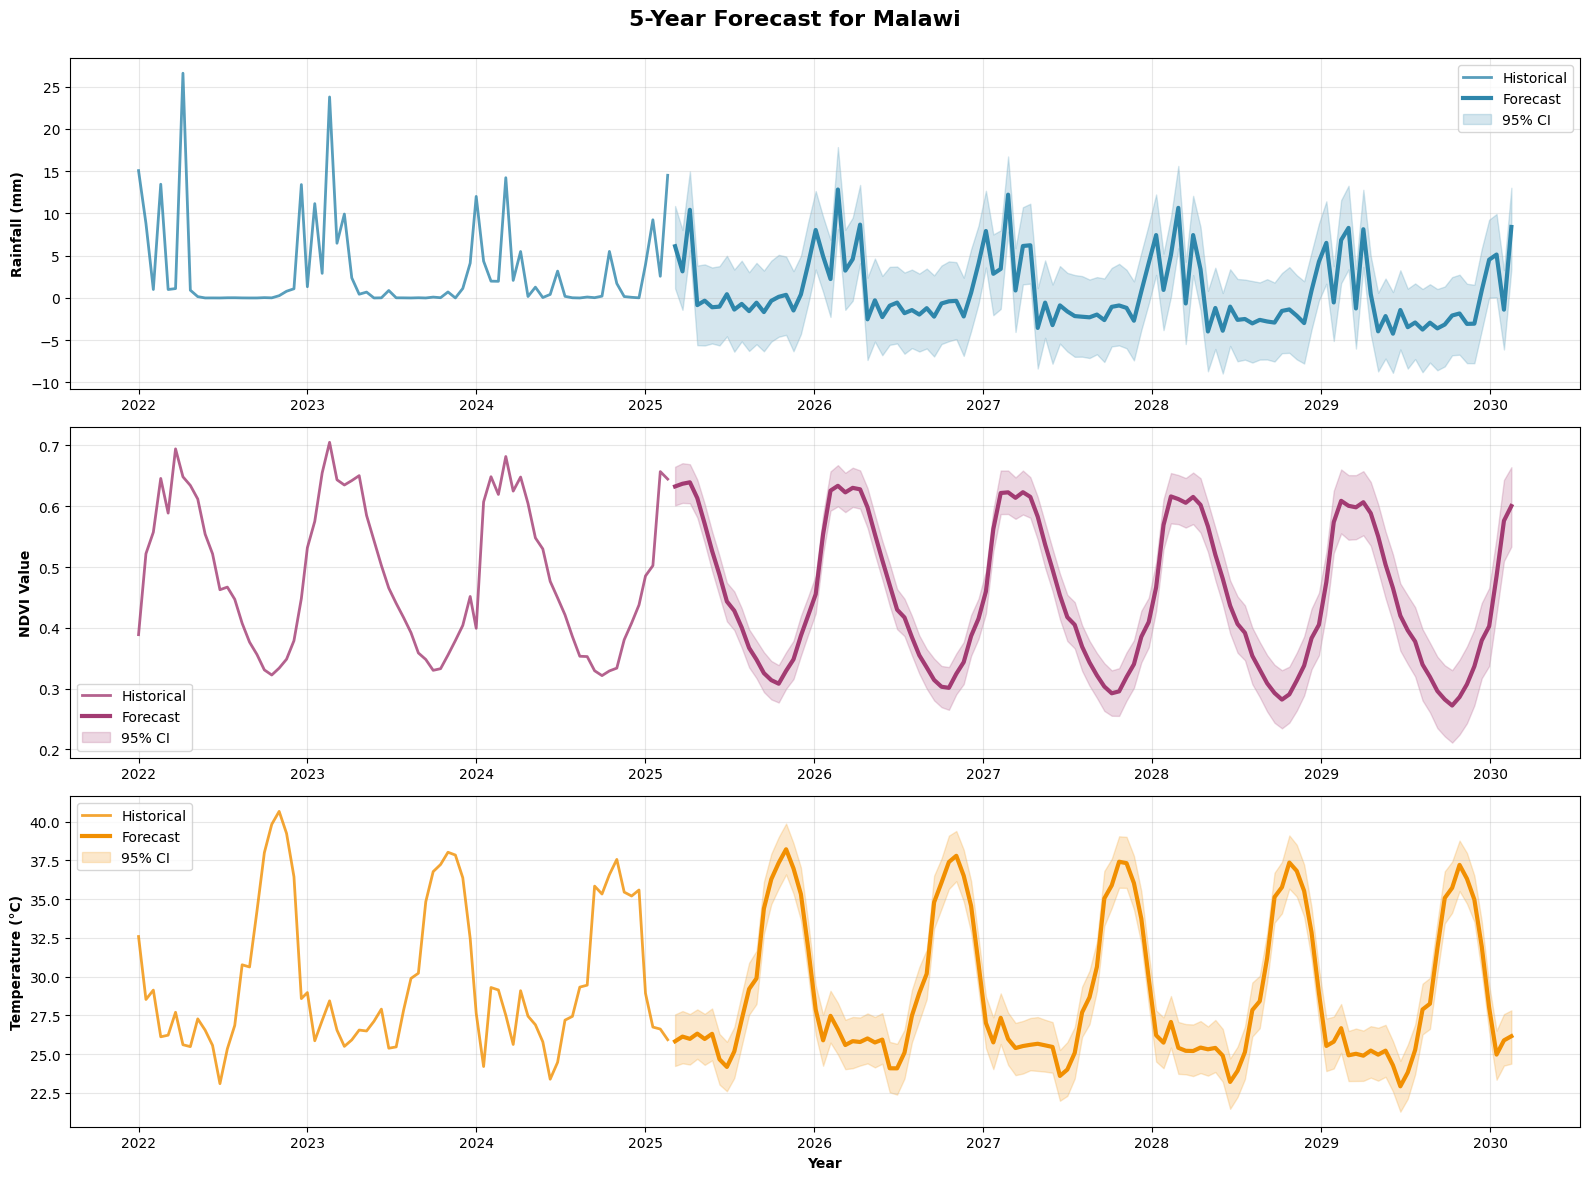


📊 FORECAST SUMMARY: Malawi

📅 Forecast Period: 2025-03-06 to 2030-02-16

🌧️  Rainfall Forecast:
   Average: 0.6 mm
   Range: -4.2 - 12.8 mm

🌿 Vegetation Health (NDVI):
   Average: 0.450
   Range: 0.272 - 0.639

🌡️  Temperature Forecast:
   Average: 28.9°C
   Range: 22.9 - 38.2°C

🌾 CROP RECOMMENDATION FOR Malawi
Based on the average forecasted conditions:
  🌾 Recommended Crop: Cassava
  🧠 Reason: Warmer conditions, even with moderate NDVI, favor drought-tolerant Cassava.

💾 Forecast saved to: forecast_malawi.csv

Thank you for using the Climate Forecasting System! 👋


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# --- Crop Recommendation Logic ---
def recommend_crop(avg_temp, avg_ndvi):
    """
    Recommends a crop (Rice, Cassava, Maize) based on average forecasted
    Temperature (LST) and NDVI.

    Logic based on patterns observed in combined_with_plants.csv:
    - Cassava: High Temp + High/Moderate NDVI, or High Temp + Low NDVI (drought tolerant)
    - Rice: Moderate Temp + High NDVI (implies sufficient water)
    - Maize: Moderate/Slighly Lower Temp + Moderate NDVI, or Lower Temp overall
    """
    # Define thresholds based on data analysis (these can be fine-tuned)
    high_temp_threshold = 29.0 # Degrees Celsius
    moderate_temp_upper = 31.0 # Upper bound for "moderate"
    moderate_ndvi_threshold = 0.55 # NDVI value

    recommendation = "Unclassified" # Default

    if avg_temp > high_temp_threshold:
        # Hot region - Cassava is very common here
        if avg_ndvi > moderate_ndvi_threshold:
            # Hot and healthy vegetation
            recommendation = "Cassava"
            reason = "High temperature and high NDVI are ideal for Cassava."
        else:
            # Hot but stressed vegetation
            recommendation = "Cassava"
            reason = "High temperature; Cassava is the most drought-tolerant option."
    else:
        # Moderate or Lower temperature region
        if avg_ndvi > moderate_ndvi_threshold:
            # Healthy vegetation
            if high_temp_threshold < avg_temp <= moderate_temp_upper:
                # Moderate temp + High NDVI - Ideal for Rice (needs lots of water)
                recommendation = "Rice"
                reason = "Moderate temperature with high NDVI suggests good water availability, suitable for Rice."
            else:
                # Cooler temp + High NDVI - Could be Maize or Rice
                # Slightly favor Maize for cooler climates, but Rice is possible
                if avg_temp <= high_temp_threshold: # Being more specific
                     recommendation = "Maize"
                     reason = "Moderate/lower temperature with high NDVI, suitable for Maize."
                else: # Edge case, still moderate
                     recommendation = "Rice"
                     reason = "Conditions support high vegetation health, suitable for Rice."
        else:
            # Stressed or moderate vegetation
            # Likely Maize or Cassava (Rice less likely if NDVI is low)
            if avg_temp > high_temp_threshold - 1.5: # Slightly relaxed hot condition
                recommendation = "Cassava"
                reason = "Warmer conditions, even with moderate NDVI, favor drought-tolerant Cassava."
            else:
                recommendation = "Maize"
                reason = "Moderate/lower temperature with moderate/low NDVI suits Maize."

    # Fallback if somehow unclassified (shouldn't happen with above logic)
    if recommendation == "Unclassified":
         if avg_temp > high_temp_threshold:
              recommendation = "Cassava"
              reason = "Defaulting to Cassava for high temperature."
         elif avg_ndvi > moderate_ndvi_threshold:
              recommendation = "Rice"
              reason = "Defaulting to Rice for high NDVI with non-extreme temp."
         else:
              recommendation = "Maize"
              reason = "Defaulting to Maize for other conditions."

    return recommendation, reason
# --- End Crop Recommendation Logic ---


# --- Forecasting System ---
def create_region_mapping(combined_df):
    """
    Create a mapping of GID_2 codes to human-readable region names
    """
    # Extract unique GID_2 codes and create meaningful names
    unique_gids = combined_df['GID_2'].unique()

    # Malawi region mapping (approximate - you can customize this)
    # Note: The actual GIDs in your data might be slightly different (e.g., MWI.1.1_1)
    # This mapping is based on the initial code, adjust if needed for your specific GIDs
    malawi_regions = {
        'MWI.1.1_1': 'Northern Region - Chitipa',
        'MWI.1.2_1': 'Northern Region - Karonga',
        'MWI.1.3_1': 'Northern Region - Rumphi',
        'MWI.2.1_1': 'Central Region - Kasungu',
        'MWI.2.2_1': 'Central Region - Nkhotakota',
        'MWI.2.3_1': 'Central Region - Ntchisi',
        'MWI.2.4_1': 'Central Region - Dowa',
        'MWI.2.5_1': 'Central Region - Salima',
        'MWI.2.6_1': 'Central Region - Lilongwe',
        'MWI.2.7_1': 'Central Region - Mchinji',
        'MWI.3.1_1': 'Southern Region - Mangochi',
        'MWI.3.2_1': 'Southern Region - Machinga',
        'MWI.3.3_1': 'Southern Region - Zomba',
        'MWI.3.4_1': 'Southern Region - Chiradzulu',
        'MWI.3.5_1': 'Southern Region - Blantyre',
        'MWI.3.6_1': 'Southern Region - Mwanza',
        'MWI.3.7_1': 'Southern Region - Thyolo',
        'MWI.3.8_1': 'Southern Region - Mulanje',
        'MWI.3.9_1': 'Southern Region - Phalombe',
        'MWI.4.1_1': 'Southern Region - Chikwawa',
        'MWI.4.2_1': 'Southern Region - Nsanje',
        'MWI.4.3_1': 'Southern Region - Balaka',
        'MWI.4.4_1': 'Southern Region - Neno',
        # Add more specific mappings if you find them in your data
        # Based on the data sample, many more GIDs exist, but full mapping is extensive
    }

    # Add more mappings as needed for other countries (if present in data)
    region_mapping = {}
    for gid in unique_gids:
        if gid in malawi_regions:
            region_mapping[gid] = malawi_regions[gid]
        else:
            # Generic naming for unknown regions
            region_mapping[gid] = f"Region {gid}"

    return region_mapping

def get_available_options(combined_df):
    """
    Get available countries and regions for user selection
    """
    # Extract country codes from GID_2 (first 3 letters)
    combined_df['country_code'] = combined_df['GID_2'].str.slice(0, 3)

    # Map country codes to full names
    country_mapping = {
        'MWI': 'Malawi',
        'GHA': 'Ghana',
        'UGA': 'Uganda',
        'SEN': 'Senegal',
        'BEN': 'Benin'
    }

    available_countries = {}
    for code in combined_df['country_code'].unique():
        country_name = country_mapping.get(code, f"Country_{code}")
        available_countries[code] = country_name

    return available_countries, create_region_mapping(combined_df)

def display_available_options(available_countries, region_mapping):
    """
    Display available options to the user
    """
    print("🌍 AVAILABLE COUNTRIES:")
    print("=" * 40)
    for code, name in available_countries.items():
        print(f"{code}: {name}")

    print("\n📍 AVAILABLE REGIONS (for detailed analysis):")
    print("=" * 60)
    # Show first 15 regions for better visibility
    region_items = list(region_mapping.items())
    for gid, name in region_items[:15]:
        print(f"{gid}: {name}")

    if len(region_mapping) > 15:
        print(f"... and {len(region_mapping) - 15} more regions")

    print(f"\n💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analysis")

def get_user_selection(available_countries, region_mapping):
    """
    Get user input for country/region selection
    """
    while True:
        print("\n" + "=" * 60)
        user_input = input("Enter country name (e.g., 'Malawi') or GID code (e.g., 'MWI.1.1_1'): ").strip()

        # Check for country name
        country_lower = user_input.lower()
        for code, name in available_countries.items():
            if country_lower == name.lower():
                return {'type': 'country', 'value': code, 'name': name}

        # Check for GID code
        if user_input in region_mapping:
            return {'type': 'region', 'value': user_input, 'name': region_mapping[user_input]}

        # Check for "malawi" specifically
        if country_lower == 'malawi':
            return {'type': 'country', 'value': 'MWI', 'name': 'Malawi'}

        print("❌ Invalid selection. Please choose from the available options.")
        display_available_options(available_countries, region_mapping)

def prepare_data_for_forecast(combined_df, selection, forecast_years=5):
    """
    Prepare data based on user selection
    """
    if selection['type'] == 'country':
        # Country-level analysis - aggregate all regions for that country
        country_code = selection['value']
        country_data = combined_df[combined_df['GID_2'].str.startswith(country_code)]

        if country_data.empty:
            print(f"❌ No data found for country code: {country_code}")
            return None

        # Aggregate by date
        aggregated_data = country_data.groupby('DATE').agg({
            'RAINFALL_MM': 'mean',
            'NDVI_VALUE': 'mean',
            'LST_VALUE': 'mean'
        }).sort_index()

        print(f"✅ Prepared country-level data for {selection['name']}")
        print(f"   Time range: {aggregated_data.index.min()} to {aggregated_data.index.max()}")
        print(f"   Total records: {len(aggregated_data)}")

        return aggregated_data

    else:
        # Region-level analysis
        region_gid = selection['value']
        region_data = combined_df[combined_df['GID_2'] == region_gid].sort_values('DATE')

        if region_data.empty:
            print(f"❌ No data found for region: {region_gid}")
            return None

        region_data = region_data.set_index('DATE')[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']]

        print(f"✅ Prepared region-level data for {selection['name']}")
        print(f"   Time range: {region_data.index.min()} to {region_data.index.max()}")
        print(f"   Total records: {len(region_data)}")

        return region_data

def prophet_forecast(series, periods=115, yearly_seasonality=True):
    """
    Use Facebook's Prophet for robust forecasting
    """
    try:
        from prophet import Prophet
    except ImportError:
        raise ImportError("The 'prophet' library is required for forecasting. Please install it using 'pip install prophet'.")

    # Prophet requires a DataFrame with columns 'ds' (datetime) and 'y' (value)
    prophet_df = pd.DataFrame({
        'ds': series.index,
        'y': series.values
    })

    # Create and fit the Prophet model
    model = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    model.fit(prophet_df)

    # Create future dates for forecasting
    future = model.make_future_dataframe(periods=periods, freq='16D') # Assuming 16-day MODIS intervals

    # Predict
    forecast = model.predict(future)

    # Extract forecasted values for the future period only
    forecast_series = forecast.set_index('ds')['yhat'][-periods:]
    confidence_lower = forecast.set_index('ds')['yhat_lower'][-periods:]
    confidence_upper = forecast.set_index('ds')['yhat_upper'][-periods:]

    return forecast_series, confidence_lower, confidence_upper

def run_forecast(data, selection, forecast_years=5):
    """
    Run the forecasting pipeline
    """
    # Calculate periods based on 16-day intervals (MODIS)
    # 5 years * 365 days/year / 16 days/period
    periods = int(365 * forecast_years / 16)
    if periods <= 0:
        periods = 60 # Default fallback if calculation goes wrong

    print(f"\n🔮 Forecasting for {selection['name']} ({forecast_years} years)...")

    # Forecast each variable
    rainfall_forecast, rain_lower, rain_upper = prophet_forecast(data['RAINFALL_MM'], periods)
    ndvi_forecast, ndvi_lower, ndvi_upper = prophet_forecast(data['NDVI_VALUE'], periods)
    lst_forecast, lst_lower, lst_upper = prophet_forecast(data['LST_VALUE'], periods)

    # Create a DataFrame containing the forecasted values
    forecasts = pd.DataFrame({
        'RAINFALL_MM': rainfall_forecast.values,
        'NDVI_VALUE': ndvi_forecast.values,
        'LST_VALUE': lst_forecast.values
    }, index=rainfall_forecast.index) # Use the datetime index from the forecast

    # Store confidence intervals for plotting
    confidence_intervals = {
        'rainfall': {'lower': rain_lower, 'upper': rain_upper},
        'ndvi': {'lower': ndvi_lower, 'upper': ndvi_upper},
        'lst': {'lower': lst_lower, 'upper': lst_upper}
    }

    return forecasts, confidence_intervals

def plot_results(historical_data, forecasts, ci_dict, selection):
    """
    Plot forecasting results
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

    colors = ['#2E86AB', '#A23B72', '#F18F01'] # Blue, Magenta, Orange

    # Rainfall
    ax1.plot(historical_data.index, historical_data['RAINFALL_MM'],
             label='Historical', linewidth=2, color=colors[0], alpha=0.8)
    ax1.plot(forecasts.index, forecasts['RAINFALL_MM'],
             label='Forecast', linewidth=3, color=colors[0])
    ax1.fill_between(forecasts.index, ci_dict['rainfall']['lower'], ci_dict['rainfall']['upper'],
                    color=colors[0], alpha=0.2, label='95% CI')
    ax1.set_ylabel('Rainfall (mm)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # NDVI
    ax2.plot(historical_data.index, historical_data['NDVI_VALUE'],
             label='Historical', linewidth=2, color=colors[1], alpha=0.8)
    ax2.plot(forecasts.index, forecasts['NDVI_VALUE'],
             label='Forecast', linewidth=3, color=colors[1])
    ax2.fill_between(forecasts.index, ci_dict['ndvi']['lower'], ci_dict['ndvi']['upper'],
                    color=colors[1], alpha=0.2, label='95% CI')
    ax2.set_ylabel('NDVI Value', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # LST
    ax3.plot(historical_data.index, historical_data['LST_VALUE'],
             label='Historical', linewidth=2, color=colors[2], alpha=0.8)
    ax3.plot(forecasts.index, forecasts['LST_VALUE'],
             label='Forecast', linewidth=3, color=colors[2])
    ax3.fill_between(forecasts.index, ci_dict['lst']['lower'], ci_dict['lst']['upper'],
                    color=colors[2], alpha=0.2, label='95% CI')
    ax3.set_ylabel('Temperature (°C)', fontweight='bold')
    ax3.set_xlabel('Year', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.suptitle(f'5-Year Forecast for {selection["name"]}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def generate_summary(forecasts, selection):
    """
    Generate forecast summary and crop recommendation
    """
    print("\n" + "=" * 60)
    print(f"📊 FORECAST SUMMARY: {selection['name']}")
    print("=" * 60)

    # Calculate average forecasted values
    avg_rainfall = forecasts['RAINFALL_MM'].mean()
    avg_ndvi = forecasts['NDVI_VALUE'].mean()
    avg_temp = forecasts['LST_VALUE'].mean()

    print(f"\n📅 Forecast Period: {forecasts.index[0].strftime('%Y-%m-%d')} to {forecasts.index[-1].strftime('%Y-%m-%d')}")

    print(f"\n🌧️  Rainfall Forecast:")
    print(f"   Average: {avg_rainfall:.1f} mm")
    print(f"   Range: {forecasts['RAINFALL_MM'].min():.1f} - {forecasts['RAINFALL_MM'].max():.1f} mm")

    print(f"\n🌿 Vegetation Health (NDVI):")
    print(f"   Average: {avg_ndvi:.3f}")
    print(f"   Range: {forecasts['NDVI_VALUE'].min():.3f} - {forecasts['NDVI_VALUE'].max():.3f}")

    print(f"\n🌡️  Temperature Forecast:")
    print(f"   Average: {avg_temp:.1f}°C")
    print(f"   Range: {forecasts['LST_VALUE'].min():.1f} - {forecasts['LST_VALUE'].max():.1f}°C")

    # --- Add Crop Recommendation ---
    print("\n" + "=" * 60)
    print(f"🌾 CROP RECOMMENDATION FOR {selection['name']}")
    print("=" * 60)
    recommended_crop, reason = recommend_crop(avg_temp, avg_ndvi)
    print(f"Based on the average forecasted conditions:")
    print(f"  🌾 Recommended Crop: {recommended_crop}")
    print(f"  🧠 Reason: {reason}")
    print("=" * 60)
    # --- End Add Crop Recommendation ---


def main():
    """
    Main interactive forecasting system
    """
    print("🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM")
    print("=" * 50)
    print("This system predicts Rainfall, Vegetation Health, and Temperature")
    print("for any available country or region for the next 5 years!")
    print("It also provides a crop recommendation (Rice, Cassava, Maize)!")
    print("=" * 50)

    # Load your data
    try:
        # Read the entire file as a single string
        with open('combined_with_plants.csv', 'r') as f:
            content = f.read()

        # Define the regex pattern to match each data record
        # The pattern looks for:
        # - A UID (e.g., MWI.1.1_1_1/1/2022)
        # - Followed by a comma
        # - Then GID_2 (e.g., MWI.1.1_1)
        # - Then DATE (e.g., 1/1/2022)
        # - Then RAINFALL_MM (e.g., 15.44159154)
        # - Then NDVI_VALUE (e.g., 0.426636364)
        # - Then LST_VALUE (e.g., 37.39587369)
        # - Then RECOMMENDED_PLANT (e.g., Cassava)
        # The pattern uses non-greedy matching (.*?) for the UID and RECOMMENDED_PLANT
        # and specific patterns for the other fields.
        # Note: This regex assumes the date format is consistent (M/D/YYYY or MM/DD/YYYY)
        # and that numerical values are standard decimals.
        pattern = r'([^,]+),([^,]+),(\d{1,2}/\d{1,2}/\d{4}),([^,]+),([^,]+),([^,]+),([^,]+)'

        # Find all matches
        matches = re.findall(pattern, content)

        if not matches:
            raise ValueError("No data records could be parsed from the file using the regex pattern.")

        # Create lists to hold the parsed data
        uids = []
        gids = []
        dates = []
        rainfall = []
        ndvi = []
        lst = []
        plants = []

        # Populate the lists
        for match in matches:
            uids.append(match[0])
            gids.append(match[1])
            # Parse the date string
            try:
                date_obj = datetime.strptime(match[2], '%m/%d/%Y')
                dates.append(date_obj)
            except ValueError:
                print(f"Warning: Could not parse date '{match[2]}'. Skipping record.")
                continue # Skip records with unparsable dates
            try:
                rainfall.append(float(match[3]))
                ndvi.append(float(match[4]))
                lst.append(float(match[5]))
                plants.append(match[6])
            except ValueError:
                print(f"Warning: Could not parse numerical values in record UID '{match[0]}'. Skipping record.")
                continue # Skip records with unparsable numbers

        # Create the DataFrame
        combined_df = pd.DataFrame({
            'UID': uids,
            'GID_2': gids,
            'DATE': dates,
            'RAINFALL_MM': rainfall,
            'NDVI_VALUE': ndvi,
            'LST_VALUE': lst,
            'RECOMMENDED_PLANT': plants
        })

        # Drop any remaining rows with missing critical data (should be minimal after regex)
        combined_df = combined_df.dropna(subset=['DATE', 'RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE'])
        combined_df = combined_df.reset_index(drop=True) # Reset index after potential drops

        if combined_df.empty:
            raise ValueError("No valid data found after parsing and cleaning.")

    except FileNotFoundError:
        print("❌ Error: File 'combined_with_plants.csv' not found. Please ensure the file is in the correct directory.")
        return
    except Exception as e:
        print(f"❌ Error loading  {e}")
        return

    print(f"✅ Data loaded and parsed successfully. Total records: {len(combined_df)}")

    # Get available options for user selection
    available_countries, region_mapping = get_available_options(combined_df)

    while True:
        # Display options and get user selection
        display_available_options(available_countries, region_mapping)
        selection = get_user_selection(available_countries, region_mapping)

        # Prepare data based on user selection
        data = prepare_data_for_forecast(combined_df, selection)
        if data is None or data.empty:
            print("⚠️  Unable to prepare data for forecasting. Please try another selection.")
            continue

        # Run the forecasting pipeline
        try:
            forecasts, ci_dict = run_forecast(data, selection)
        except Exception as e:
             print(f"❌ Error during forecasting: {e}")
             continue

        # Plot the results
        try:
            plot_results(data, forecasts, ci_dict, selection)
        except Exception as e:
             print(f"⚠️  Could not display plot: {e}")

        # Generate summary (including crop recommendation)
        generate_summary(forecasts, selection)

        # Save results to a CSV file
        filename = f"forecast_{selection['name'].replace(' ', '_').lower()}.csv"
        try:
            forecasts.to_csv(filename)
            print(f"\n💾 Forecast saved to: {filename}")
        except Exception as e:
            print(f"⚠️  Could not save forecast to file: {e}")

        # Ask if user wants to continue
        print("\n" + "=" * 50)
        continue_choice = input("Would you like to forecast another region? (yes/no): ").strip().lower()
        if continue_choice not in ['yes', 'y']:
            print("Thank you for using the Climate Forecasting System! 👋")
            break

# Run the interactive system
if __name__ == "__main__":
    main()